# Section 5.5 — Hierarchical models

This notebook contains the code examples from [Section 5.5 Hierarchical models]() from the **No Bullshit Guide to Statistics**.

See also:
- [03_hierarchical_model.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/03_hierarchical_model.ipynb)
- [cs109b_lect13_bayes_2_2021.ipynb](./explorations/cs109b_lect13_bayes_2_2021.ipynb)
- https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section4-Hierarchical_Models.ipynb
- https://mc-stan.org/users/documentation/case-studies/radon_cmdstanpy_plotnine.html#data-prep
- https://github.com/mitzimorris/brms_feb_28_2023/blob/main/brms_notebook.Rmd
- https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################


In [4]:
# silence statsmodels kurtosistest warning when using n < 20
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Definitions

### Hierarchical (multilevel) models

### Model formula

A Bayesian hierarchical model is described by the following equations:

$\def\calN{\mathcal{N}}
 \def\Tdist{\mathcal{T}}
 \def\Expon{\mathrm{Expon}}$

\begin{align*}
    X_j			&\sim	\calN(M_{j}, \, \Sigma_X),  \\
    M_{j}		&=		B_0 + B_{0j},					\\
    \Sigma_X	&\sim	\Tdist^+\!(\nu_{\Sigma_X}, \sigma_{\Sigma_X}), \\
    B_0			&\sim	\calN(\mu_{B_0},\sigma_{B_0}), \\
    B_{0j}		&\sim	\calN(0,\Sigma_{B_{0j}}), \\
    \Sigma_{B_{0j}}	&\sim	\Expon(\lambda).
\end{align*}

## Radon dataset

https://bambinos.github.io/bambi/notebooks/radon_example.html

- Description: Contains measurements of radon levels in homes across various counties.
- Source: Featured in Andrew Gelman and Jennifer Hill's book Data Analysis Using Regression and Multilevel/Hierarchical Models.
- Application: Demonstrates partial pooling and varying intercepts/slopes in hierarchical modeling.


### Loading the data

In [5]:
radon = pd.read_csv("../datasets/radon.csv")
radon.shape

(919, 6)

In [6]:
radon.head()

,idnum,state,county,floor,log_radon,log_uranium
0,5081,MN,AITKIN,ground,0.788457,-0.689048
1,5082,MN,AITKIN,basement,0.788457,-0.689048
2,5083,MN,AITKIN,basement,1.064711,-0.689048
3,5084,MN,AITKIN,basement,0.000000,-0.689048
4,5085,MN,ANOKA,basement,1.131402,-0.847313


### Descriptive statistics

In [7]:
radon["log_radon"].describe()

count    919.000000
mean       1.224623
std        0.853327
min       -2.302585
25%        0.641854
50%        1.280934
75%        1.791759
max        3.875359
Name: log_radon, dtype: float64

In [8]:
len(radon["county"].unique())

85

In [9]:
radon["floor"].value_counts()

floor
basement    766
ground      153
Name: count, dtype: int64

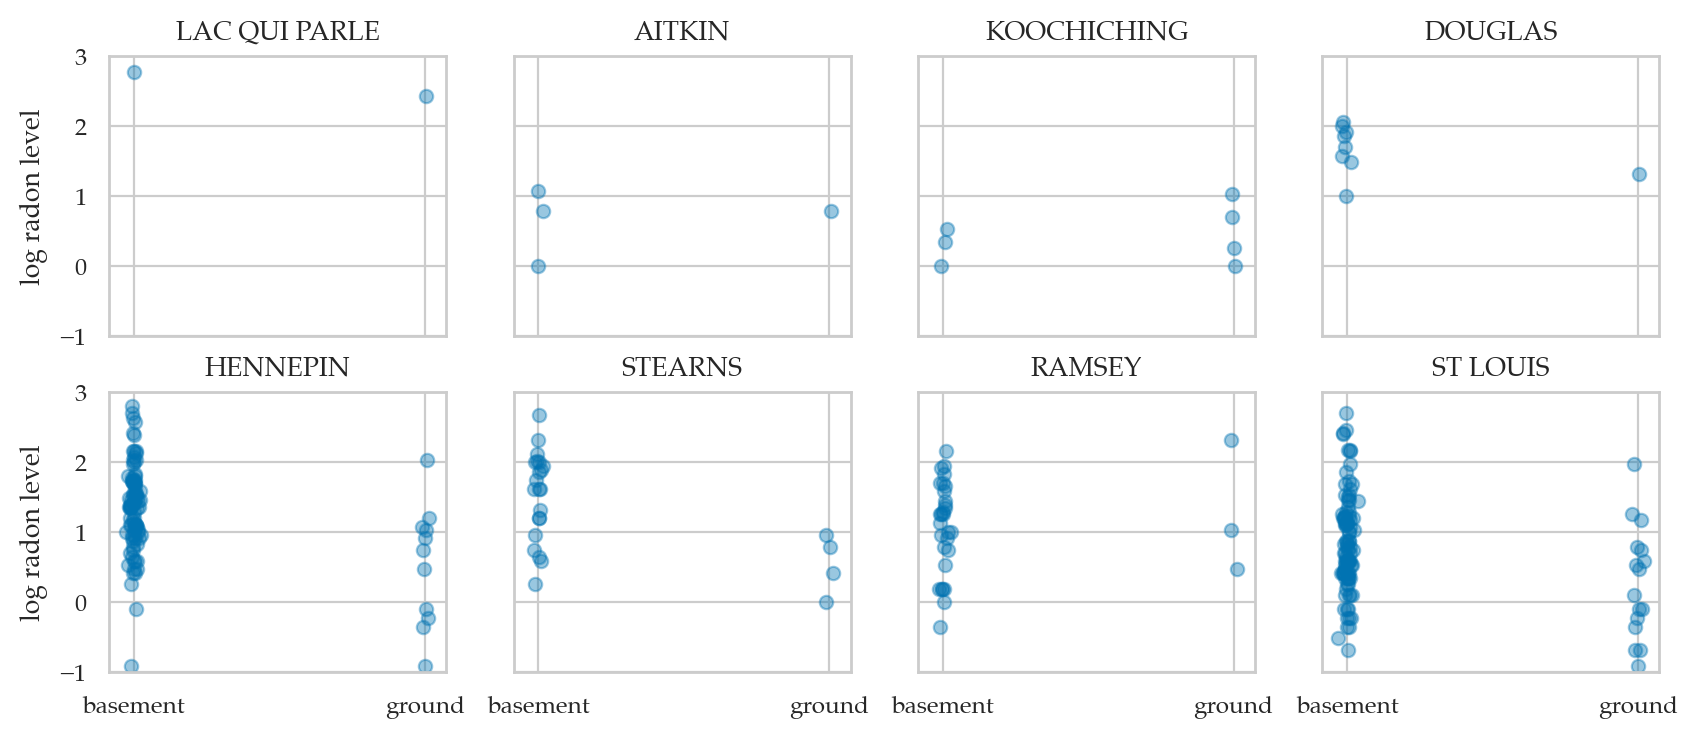

In [10]:
from ministats.book.figures import plot_counties
sel_counties = [
  "LAC QUI PARLE", "AITKIN", "KOOCHICHING", "DOUGLAS",
  "HENNEPIN", "STEARNS", "RAMSEY", "ST LOUIS",
]
plot_counties(radon, counties=sel_counties);

## Example 1: complete pooling model

= common linear regression model for all counties

### Bayesian model


We can  pool all the data and estimate one big regression to asses the influence of the floor variable
on radon levels across all counties.

\begin{align*}
    R			&\sim	\calN(M_R, \, \Sigma_R),  	\\
    M_R			&=		B_0 + B_{\!f}\!\cdot\!f,	\\
    \Sigma_R	&\sim	\Tdist^+\!(4, 1),			\\
    B_0			&\sim	\calN(1, 2), 				\\
    B_f			&\sim	\calN(0, 5).
\end{align*}

The variable $f$ corresponds to the column `floor` in the `radon` data frame,
which will be internally coded as binary
with $0$ representing basement,
and $1$ representing ground floor.

By ignoring the county feature, we do not differenciate on counties.

### Bambi model


In [11]:
import bambi as bmb

priors1 = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=2),
    "floor": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

mod1 = bmb.Model(formula="log_radon ~ 1 + floor",
                 family="gaussian",
                 link="identity",
                 priors=priors1,
                 data=radon)
mod1

       Formula: log_radon ~ 1 + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 2.0)
            floor ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

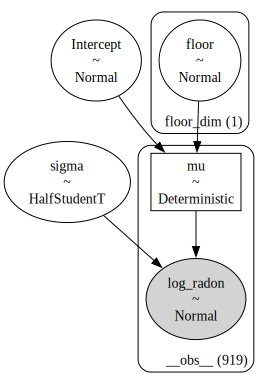

In [12]:
mod1.build()
mod1.graph()

### Model fitting and analysis

In [13]:
idata1 = mod1.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [14]:
import arviz as az

az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,1.327,0.030,1.271,1.383
floor[ground],-0.615,0.074,-0.754,-0.477
sigma,0.824,0.020,0.787,0.860


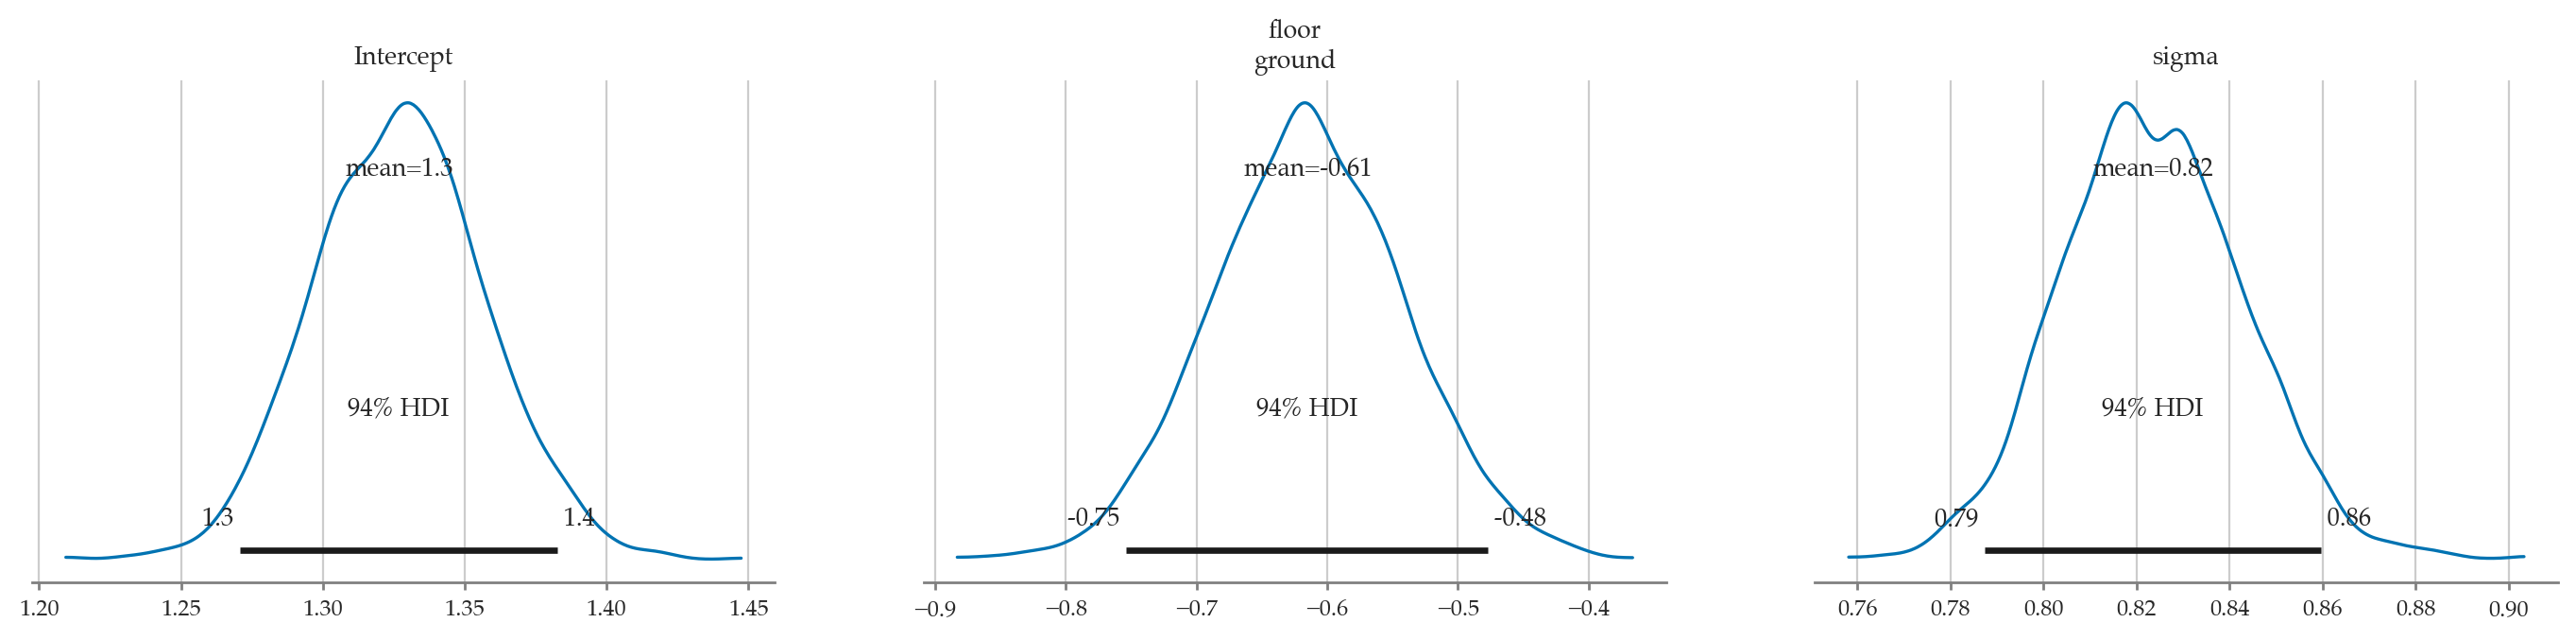

In [15]:
az.plot_posterior(idata1);

Default computed for conditional variable: floor


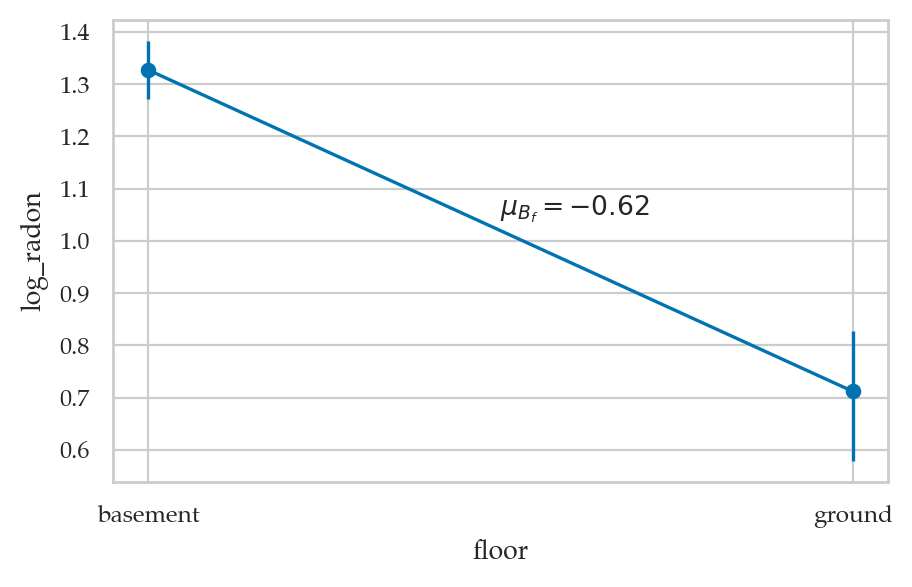

In [16]:
fig, axs = bmb.interpret.plot_predictions(mod1, idata1, conditional="floor")

means1 = az.summary(idata1, kind="stats")["mean"]
y0 = means1["Intercept"]
y1 = means1["Intercept"] + means1["floor[ground]"]
sns.lineplot(x=[0,1], y=[y0,y1], ax=axs[0]);

midpoint = [0.5, (y0+y1)/2 + 0.03]
slope = means1["floor[ground]"].round(2)
axs[0].annotate("$\\mu_{B_{f}}=%.2f$" % slope, midpoint);

### Conclusion

not using group membership, so we have lots of bias


## Example 2: no pooling model

= separate intercept for each county 

### Bayesian model

If we treat different counties as independent,
so each one gets an intercept term:

\begin{align*}
    R_j			&\sim	\calN(M_j, \, \Sigma_R),  					\\
    M_j			&=		B_{0j} + B_{\!f}\!\cdot\!f,					\\
    \Sigma_R		&\sim	\Tdist^+\!(4, 1),							\\
    B_{0j}		&\sim	\calN(1, 2),							\\
    B_f			&\sim	\calN(0, 5).
\end{align*}

### Bambi model


In [17]:
priors2 = {
    "county": bmb.Prior("Normal", mu=1, sigma=2),
    "floor": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

mod2 = bmb.Model("log_radon ~ 0 + county + floor",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=radon)
mod2

       Formula: log_radon ~ 0 + county + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            county ~ Normal(mu: 1.0, sigma: 2.0)
            floor ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

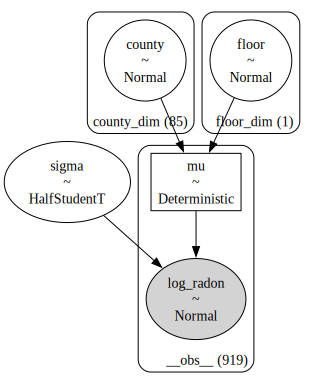

In [18]:
mod2.build()
mod2.graph()

### Model fitting and analysis

In [19]:
idata2 = mod2.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, county, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [20]:
idata2sel = idata2.sel(county_dim=sel_counties)
az.summary(idata2sel, kind="stats")

,mean,sd,hdi_3%,hdi_97%
county[LAC QUI PARLE],2.829,0.518,1.852,3.817
county[AITKIN],0.852,0.377,0.119,1.527
county[KOOCHICHING],0.823,0.284,0.271,1.340
county[DOUGLAS],1.718,0.248,1.253,2.161
county[HENNEPIN],1.358,0.074,1.218,1.497
county[STEARNS],1.487,0.150,1.217,1.782
county[RAMSEY],1.156,0.132,0.918,1.414
county[ST LOUIS],0.866,0.071,0.735,1.000
floor[ground],-0.707,0.073,-0.837,-0.564
sigma,0.756,0.019,0.722,0.793


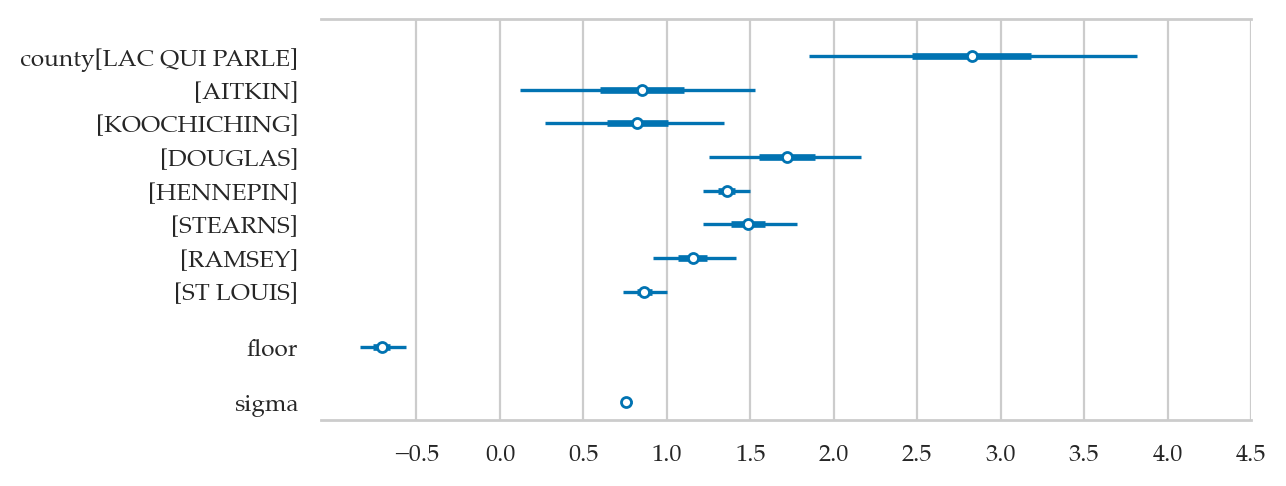

In [21]:
axs = az.plot_forest(idata2sel, combined=True, figsize=(6,2.6))
axs[0].set_xticks(np.arange(-0.5,4.6,0.5))
axs[0].set_title(None);

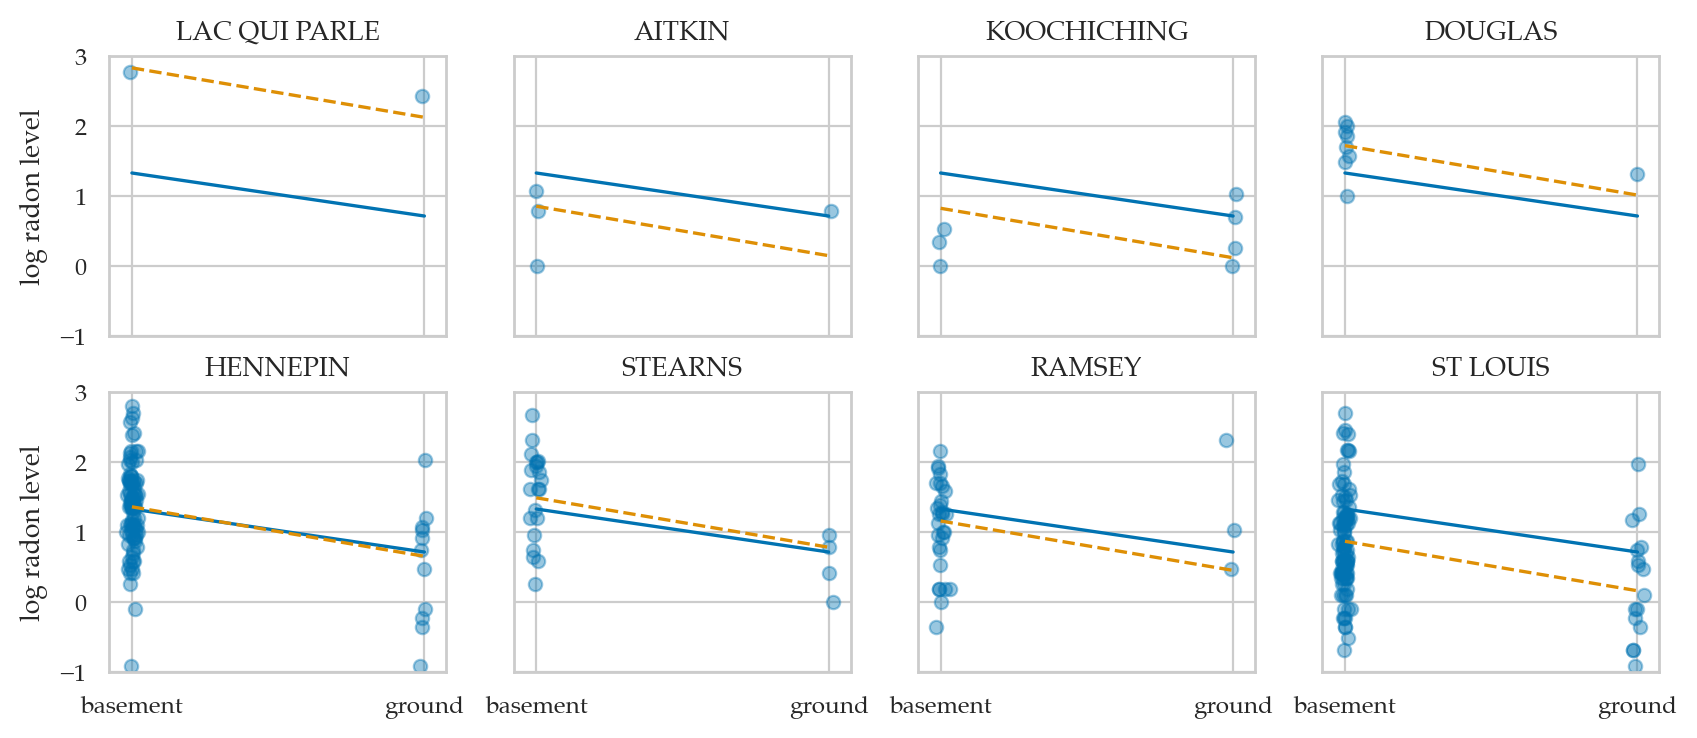

In [22]:
plot_counties(radon, idata_cp=idata1, idata_np=idata2);

In [23]:
# fig, axs = bmb.interpret.plot_predictions(mod2, idata2, ["floor", "county"]);
# axs[0].get_legend().remove()

In [24]:
# post2 = idata2["posterior"]
# unpooled_means = post2.mean(dim=("chain", "draw"))
# unpooled_hdi = az.hdi(idata2)

# unpooled_means_iter = unpooled_means.sortby("county")
# unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.county)

# _, ax = plt.subplots(figsize=(12, 5))
# unpooled_means_iter.plot.scatter(x="county_dim", y="county", ax=ax, alpha=0.9)
# ax.vlines(
#     np.arange(len(radon["county"].unique())),
#     unpooled_hdi_iter.county.sel(hdi="lower"),
#     unpooled_hdi_iter.county.sel(hdi="higher"),
#     color="orange",
#     alpha=0.6,
# )
# ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
# ax.tick_params(rotation=90);

### Conclusion
treating each group independently, so we have lots of variance


In [25]:
# TODO:
# calculate the std.dev. of the county-specific slopes -- this is like \Sigma_J but w/o a prior.

## Example 3: hierarchical model

= partial pooling model
= varying intercepts model

### Bayesian hierarchical model


\begin{align*}
    R_j			&\sim	\calN(M_j, \, \Sigma_R),						\\
    M_j			&=		B_0 + B_{0j} + B_f\!\cdot\!f,					\\
    \Sigma_R	&\sim	\Tdist^+\!(4, 1),								\\
    B_0			&\sim	\calN(1,2),										\\
    B_{0j}		&\sim	\calN(0,\Sigma_{B_{0j}}),						\\
    B_f			&\sim	\calN(0, 5),									\\
    \Sigma_{B_{0j}}	&\sim	\Expon(1).
\end{align*}


The partial pooling formula estimates per-county intercepts which drawn
from the same distribution which is estimated jointly with the rest of
the model parameters. The `1` is the intercept co-efficient. The
estimates across counties will all have the same slope.


    log_radon ~ 1 + (1|county_id) + floor


There is a middle ground to both of these extremes.
Specifically, we may assume that the intercepts are different for each county as in the unpooled case,
but they are drawn from the same distribution.
The different counties are effectively sharing information through the common prior.


NOTE: some counties have very few sample; the hierarchical model will provide "shrinkage" for these groups, and use global information learned from all counties

In [26]:
radon["log_radon"].describe()

count    919.000000
mean       1.224623
std        0.853327
min       -2.302585
25%        0.641854
50%        1.280934
75%        1.791759
max        3.875359
Name: log_radon, dtype: float64

In [27]:
radon.groupby("floor")["log_radon"].describe()

,count,mean,std,min,25%,50%,75%,max
floor,,,,,,,,
basement,766.0,1.326744,0.782709,-2.302585,0.788457,1.360977,1.883253,3.875359
ground,153.0,0.713349,0.999376,-2.302585,0.095310,0.741937,1.308333,3.234749


### Bambi model

In [28]:
priors3 = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=2),
    "floor": bmb.Prior("Normal", mu=0, sigma=5),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

formula3 = "log_radon ~ 1 + (1|county) + floor"
mod3 = bmb.Model(formula=formula3,
                 family="gaussian",
                 link="identity",
                 priors=priors3,
                 data=radon,
                 noncentered=False)

mod3

       Formula: log_radon ~ 1 + (1|county) + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 2.0)
            floor ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

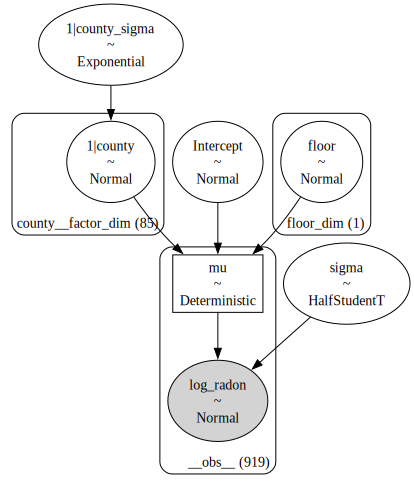

In [29]:
mod3.build()
mod3.graph()

### Model fitting and analysis

In [30]:
idata3 = mod3.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor, 1|county_sigma, 1|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


The group level parameters

In [31]:
idata3sel = idata3.sel(county__factor_dim=sel_counties)
az.summary(idata3sel, kind="stats")

,mean,sd,hdi_3%,hdi_97%
1|county[LAC QUI PARLE],0.409,0.297,-0.123,1.005
1|county[AITKIN],-0.268,0.250,-0.770,0.166
1|county[KOOCHICHING],-0.369,0.222,-0.758,0.074
1|county[DOUGLAS],0.167,0.197,-0.179,0.553
1|county[HENNEPIN],-0.099,0.088,-0.270,0.059
1|county[STEARNS],0.018,0.143,-0.248,0.284
1|county[RAMSEY],-0.262,0.134,-0.518,-0.015
1|county[ST LOUIS],-0.572,0.083,-0.726,-0.417
1|county_sigma,0.330,0.046,0.243,0.415
Intercept,1.462,0.053,1.362,1.558


The intercept offsets for each county are:

In [32]:
# sum( idata3["posterior"]["1|county"].stack(sample=("chain","draw")).values.mean(axis=1) )

In [33]:
# az.plot_forest(idata3, combined=True, figsize=(7,2),
#                var_names=["Intercept", "floor", "1|county_sigma", "sigma"]);

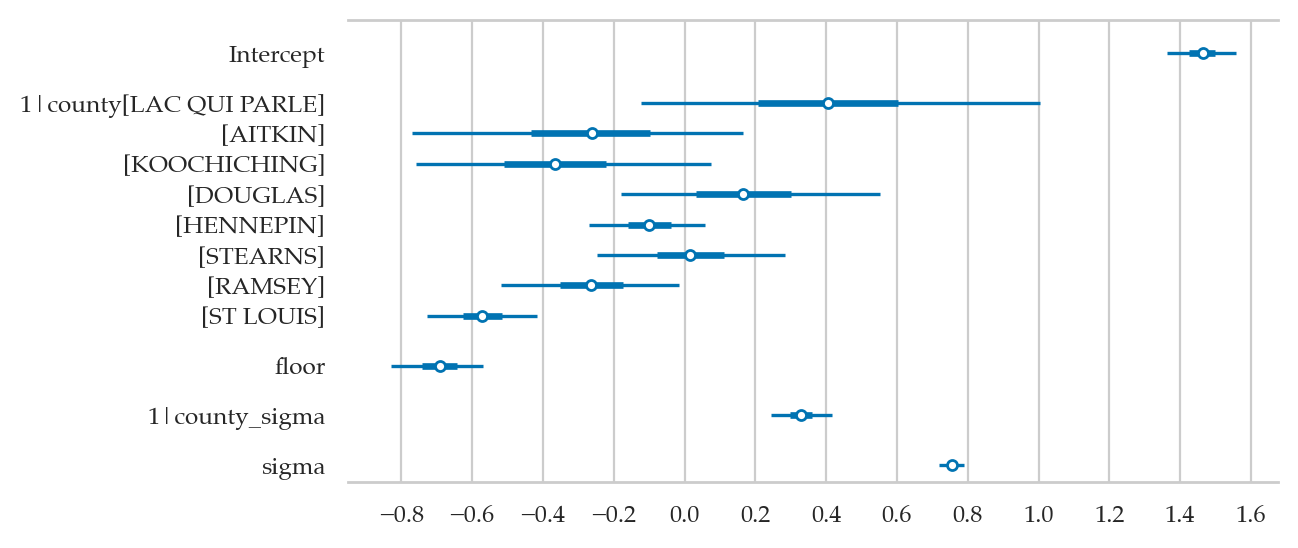

In [34]:
axs = az.plot_forest(idata3sel,
                     var_names=["Intercept", "1|county", "floor", "1|county_sigma", "sigma"],
                     combined=True, figsize=(6,3))
axs[0].set_xticks(np.arange(-0.8,1.6,0.2))
axs[0].set_title(None);

In [35]:
# az.plot_forest(idata3, var_names=["1|county"], combined=True);

### Compare models

Compare complete pooling,  no pooling, and partial pooling models


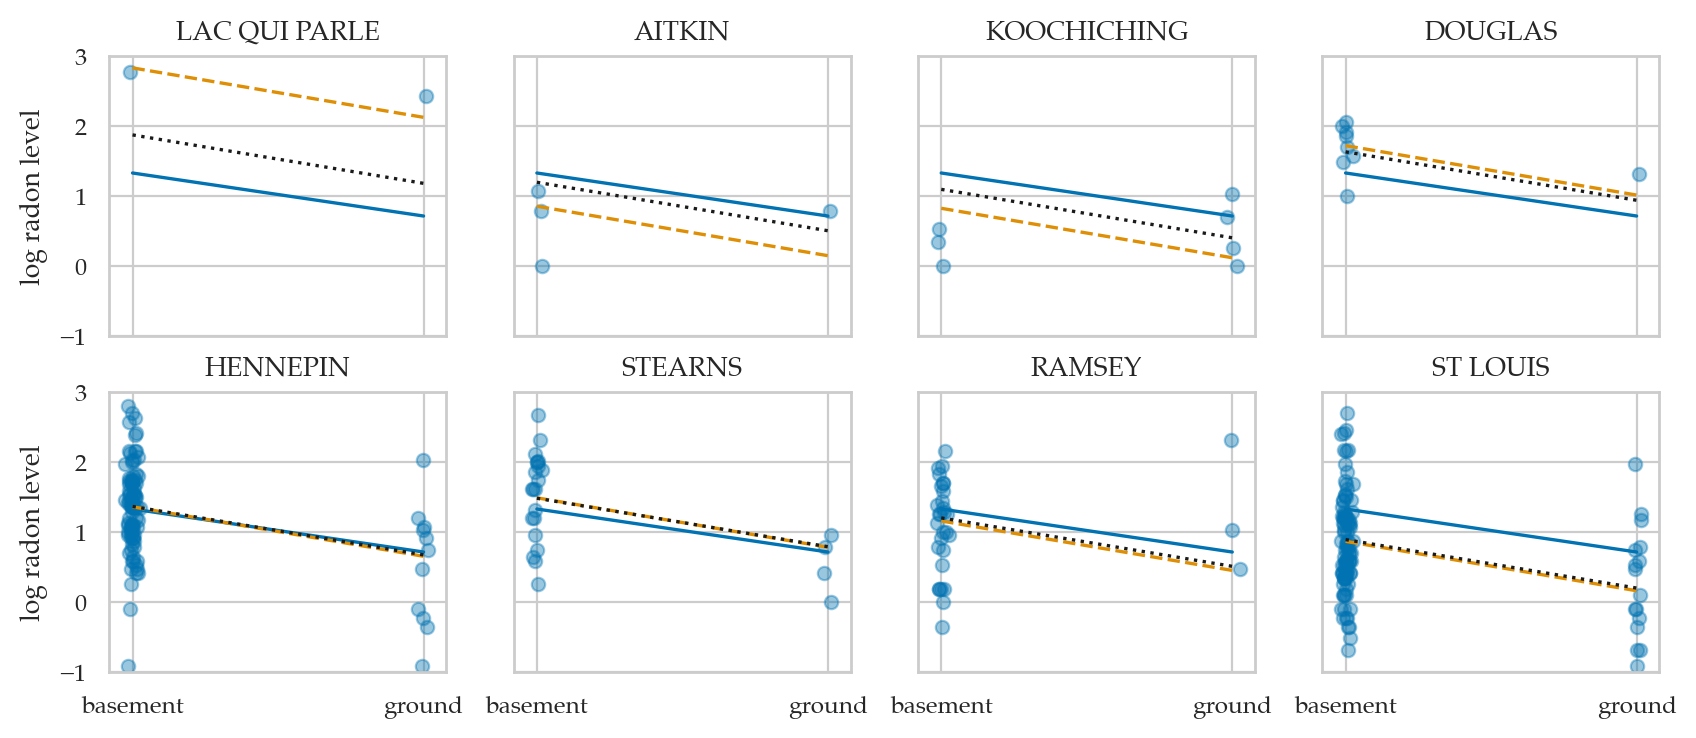

In [36]:
plot_counties(radon, idata_cp=idata1, idata_np=idata2, idata_pp=idata3);

In [37]:
# # Forest plot comparing `mod2` and `mod3` estimates
# # (to illustrate reduced uncertainty in estimates + shrinkage)
# post3 = idata3sel["posterior"]
# post3["county"] = post3["Intercept"] + post3["1|county"]
# axs = az.plot_forest([idata2sel, idata3sel], model_names=["mod2", "mod3"],
#                      var_names=["county", "floor", "1|county_sigma", "sigma"], combined=True, figsize=(6,3))
# ax = axs[0]
# rbar = radon["log_radon"].mean()
# ax.axvline(rbar, ls="--");

### Conclusions

## Explanations

### Prior selection for hierarchical models

?


### Varying intercepts and slopes model

= Group-specific slopes
We can also make beta_x group-specific


The varying-slope, varying intercept model adds `floor` to the
group-level co-efficients. Now estimates across counties will all have
varying slope.

    log_radon ~ 1 + floor + (1 + floor | county)

In [38]:
#######################################################
formula4 = "log_radon ~ 1 + (1|county) + floor + (floor|county)"

SigmaB0j = bmb.Prior("Exponential", lam=1)
SigmaBfj = bmb.Prior("Exponential", lam=1)

priors4 = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=2),
    "1|county": bmb.Prior("Normal", mu=0, sigma=SigmaB0j),
    "floor": bmb.Prior("Normal", mu=-1, sigma=2),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=SigmaBfj),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
}

mod4 = bmb.Model(formula=formula4,
                 family="gaussian",
                 link="identity",
                 priors=priors4,
                 data=radon,
                 noncentered=False)
mod4

       Formula: log_radon ~ 1 + (1|county) + floor + (floor|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 2.0)
            floor ~ Normal(mu: -1.0, sigma: 2.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
            floor|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0)

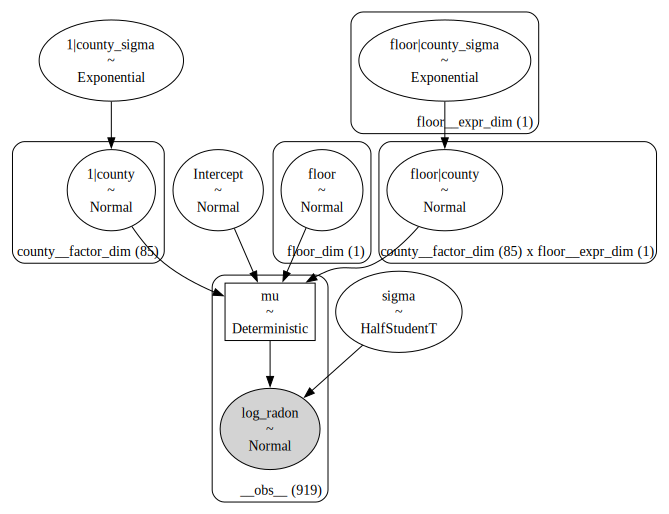

In [39]:
mod4.build()
mod4.graph()

In [40]:
idata4 = mod4.fit(draws=2000, tune=3000, random_seed=42, target_accept=0.9)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor, 1|county_sigma, 1|county, floor|county_sigma, floor|county]


Output()

Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [41]:
# az.autocorr(idata4["posterior"]["sigma"].values.flatten())[0:10]

In [42]:
idata4sel = idata4.sel(county__factor_dim=sel_counties)
az.summary(idata4sel, kind="stats")

,mean,sd,hdi_3%,hdi_97%
1|county[LAC QUI PARLE],0.407,0.305,-0.161,0.989
1|county[AITKIN],-0.291,0.252,-0.770,0.162
1|county[KOOCHICHING],-0.392,0.259,-0.838,0.152
1|county[DOUGLAS],0.167,0.204,-0.247,0.515
1|county[HENNEPIN],-0.095,0.090,-0.267,0.064
1|county[STEARNS],0.028,0.147,-0.249,0.305
1|county[RAMSEY],-0.286,0.135,-0.525,-0.038
1|county[ST LOUIS],-0.582,0.089,-0.744,-0.413
1|county_sigma,0.336,0.048,0.253,0.428
Intercept,1.464,0.054,1.359,1.562


In [43]:
az.summary(idata4, var_names="sigma", kind="stats")

,mean,sd,hdi_3%,hdi_97%
sigma,0.75,0.019,0.715,0.787


The estimated mean standard deviation is the lowest of all the models we considered so far.

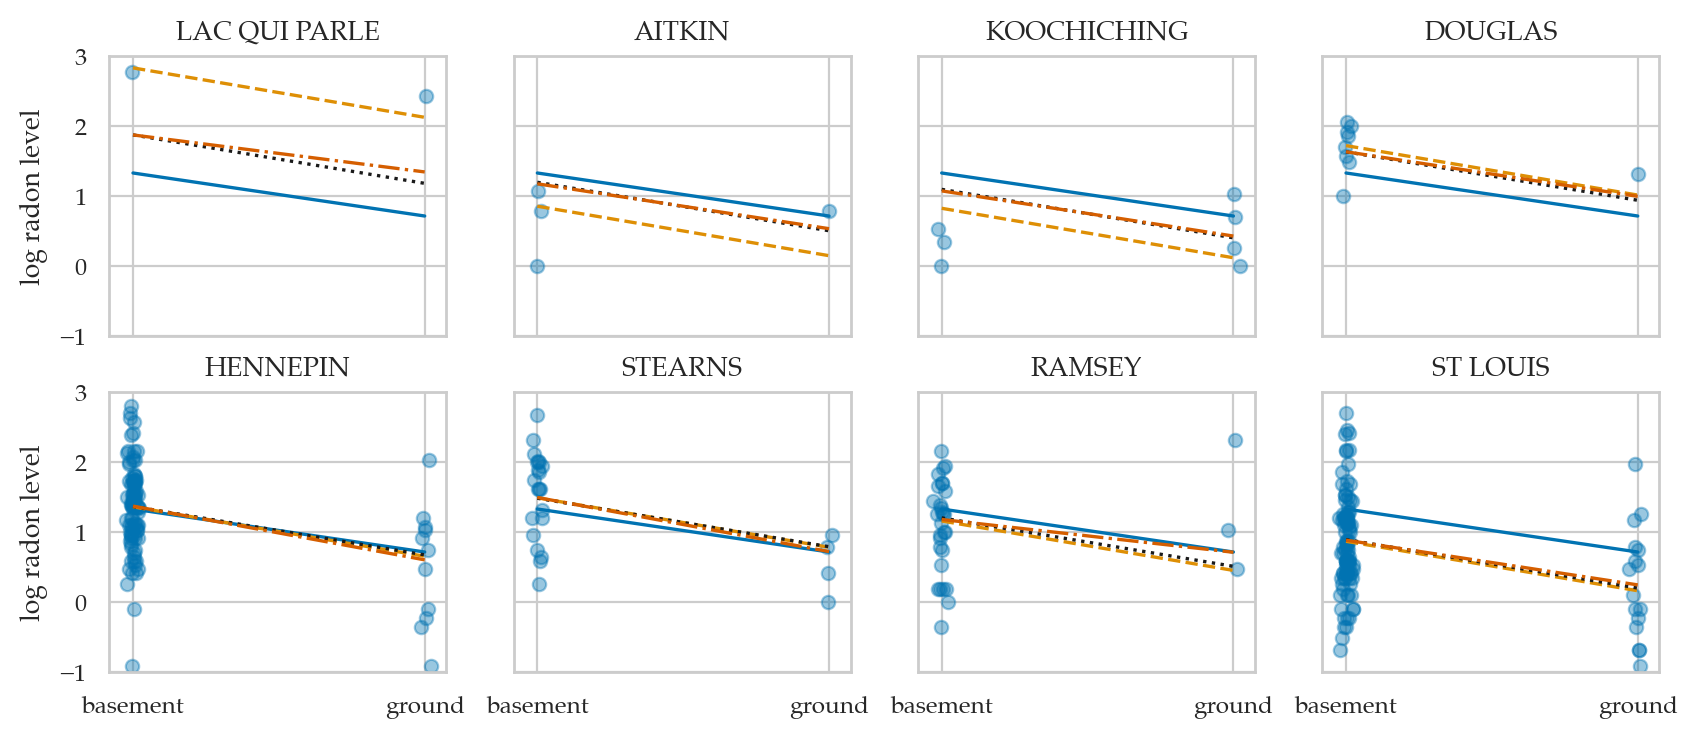

In [44]:
plot_counties(radon, idata_cp=idata1, idata_np=idata2, idata_pp=idata3, idata_pp2=idata4);

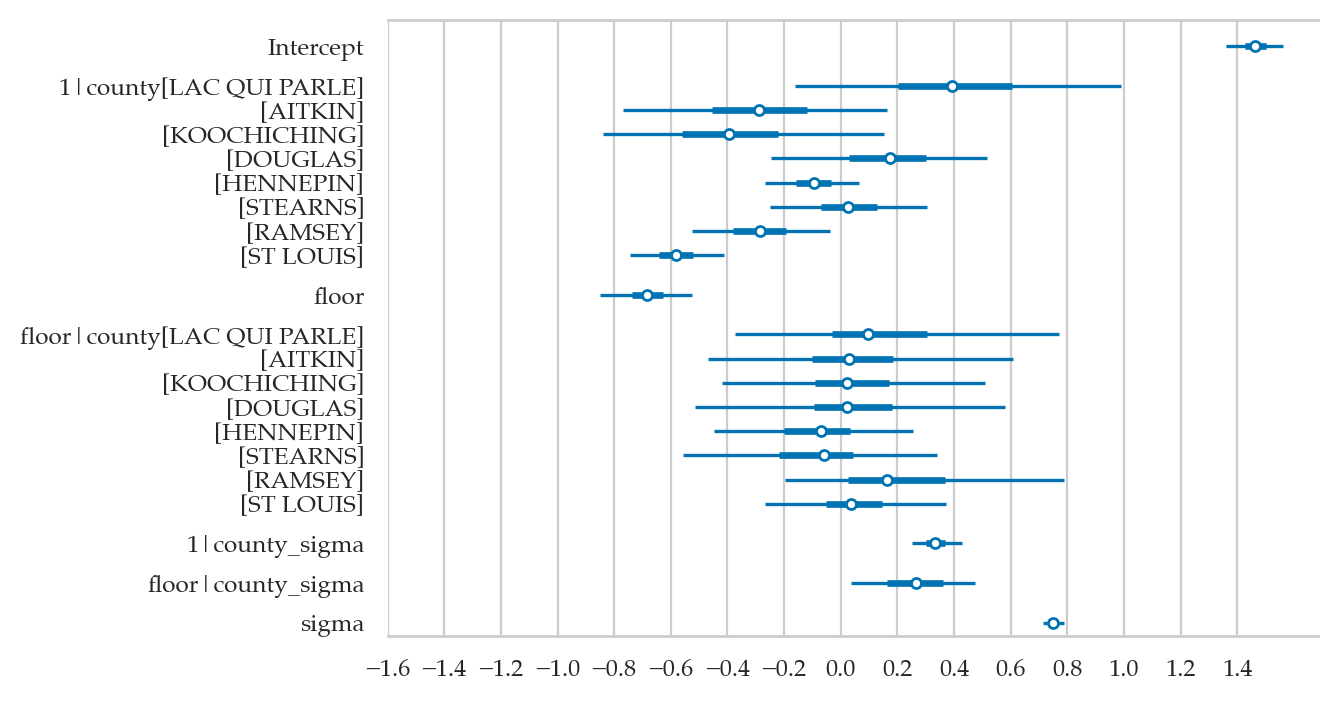

In [45]:
idata4sel = idata4.sel(county__factor_dim=sel_counties)
var_names = ["Intercept",
             "1|county",
             "floor",
             "floor|county",
             "1|county_sigma",
             "floor|county_sigma",
             "sigma"]
axs = az.plot_forest(idata4sel, combined=True, var_names=var_names, figsize=(6,4))
axs[0].set_xticks(np.arange(-1.6,1.6,0.2))
axs[0].set_title(None);

### Comparing models

In [46]:
from ministats.utils import loglevel
with loglevel("ERROR", module="pymc"):
    idata1ll = mod1.fit(idata_kwargs={"log_likelihood": True}, random_seed=42, progressbar=False)
    idata2ll = mod2.fit(idata_kwargs={"log_likelihood": True}, random_seed=42, progressbar=False)
    idata3ll = mod3.fit(idata_kwargs={"log_likelihood": True}, random_seed=42, progressbar=False)
    idata4ll = mod4.fit(idata_kwargs={"log_likelihood": True}, random_seed=42, progressbar=False,
                        draws=2000, tune=3000, target_accept=0.9)

The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Compare models based on their expected log pointwise predictive density (ELPD).

The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out cross-validation (LOO) or using the widely applicable information criterion (WAIC). We recommend loo. Read more theory here - in a paper by some of the leading authorities on model comparison dx.doi.org/10.1111/1467-9868.00353

In [47]:
radon_models = {
    "mod1 (complete pooling)": idata1ll,
    "mod2 (no pooling)": idata2ll,
    "mod3 (varying intercepts)": idata3ll,
    "mod4 (varying int. and slopes)": idata4ll,
}
compare_results = az.compare(radon_models)
compare_results

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mod3 (varying intercepts),0,-1073.801808,48.953659,0.000000,0.717722,28.163400,0.000000,False,log
mod4 (varying int. and slopes),1,-1075.982099,65.530079,2.180291,0.207706,28.897826,2.236665,True,log
mod2 (no pooling),2,-1094.764338,82.242813,20.962530,0.000070,28.075520,6.060765,True,log
mod1 (complete pooling),3,-1126.954902,3.813036,53.153095,0.074502,25.538335,10.601906,False,log


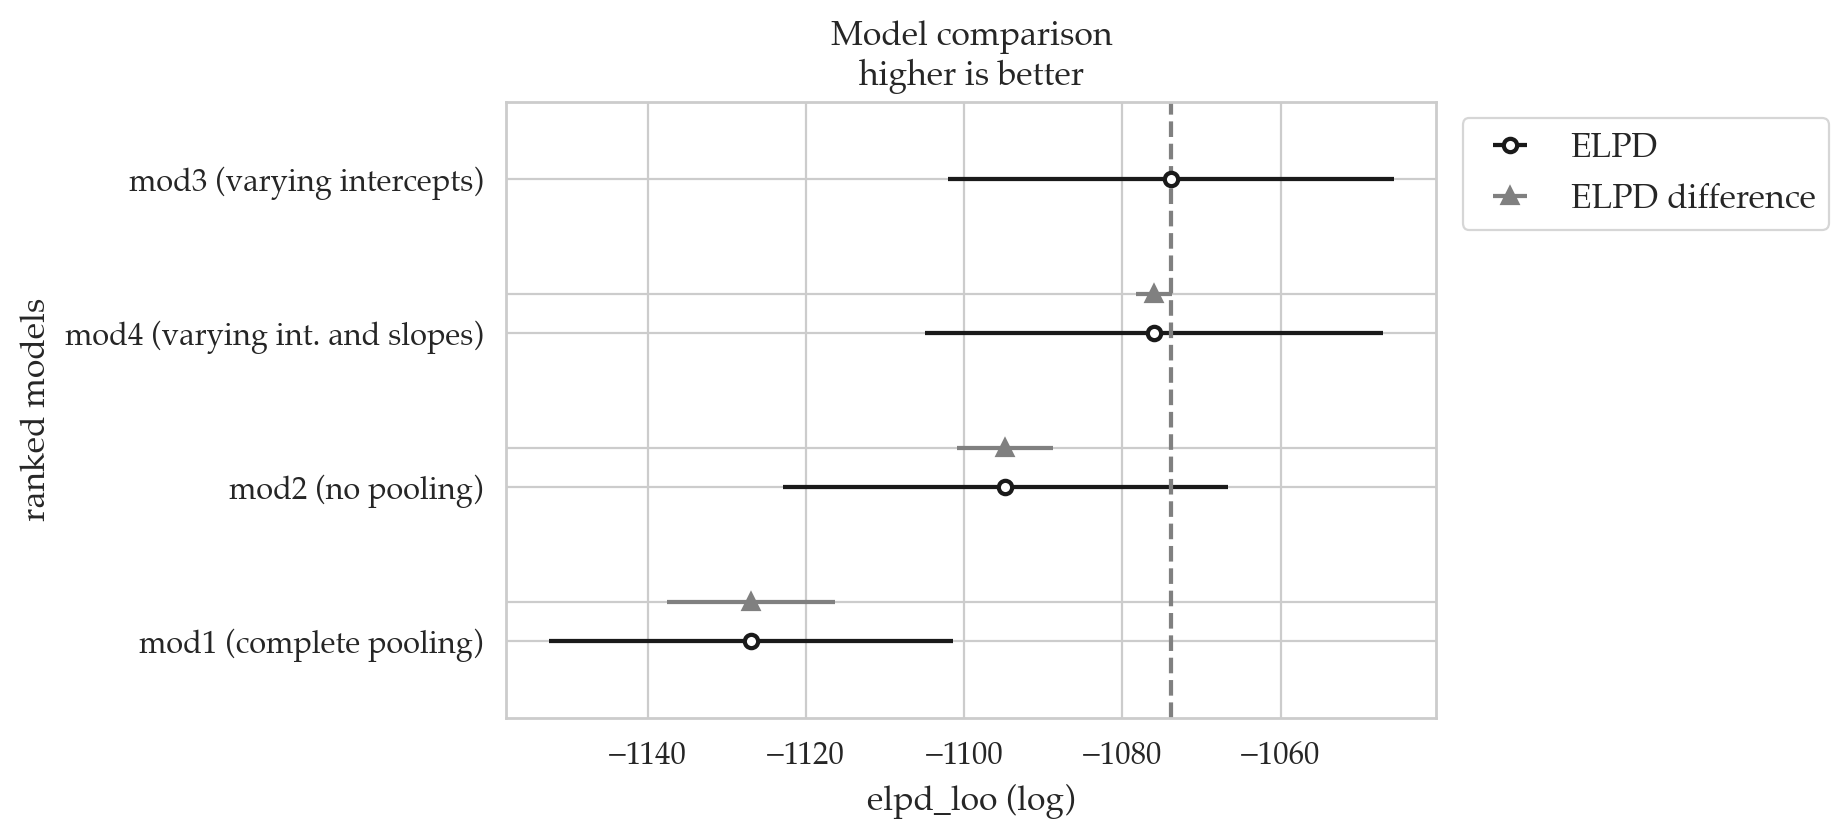

In [48]:
az.plot_compare(compare_results);

#### ELPD and elpd_loo

The ELPD is the theoretical expected log pointwise predictive density for a new dataset (Eq 1 in VGG2017), which can be estimated, e.g., using cross-validation. elpd_loo is the Bayesian LOO estimate of the expected log pointwise predictive density (Eq 4 in VGG2017) and is a sum of N individual pointwise log predictive densities. Probability densities can be smaller or larger than 1, and thus log predictive densities can be negative or positive. For simplicity the ELPD acronym is used also for expected log pointwise predictive probabilities for discrete models. Probabilities are always equal or less than 1, and thus log predictive probabilities are 0 or negative.

via https://mc-stan.org/loo/reference/loo-glossary.html

### Frequentist multilevel models

We can use `statsmodels` to fit multilevel models too.

#### Random intercepts model using `statsmodels`

In [49]:
import statsmodels.formula.api as smf
sm3 = smf.mixedlm("log_radon ~ 1 + floor",   # Fixed effects (no intercept and floor as a fixed effect)
                  groups="county",           # Grouping variable for random effects
                  re_formula="1",            # Random effects = intercept
                  data=radon)
res3 = sm3.fit()
res3.summary().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.462,0.052,28.164,0.000,1.360,1.563
floor[T.ground],-0.693,0.071,-9.818,0.000,-0.831,-0.555
county Var,0.108,0.041,,,,


In [50]:
# slope
#######################################################
res3.params["floor[T.ground]"]

-0.6929937406558049

In [51]:
# sigma-hat
np.sqrt(res3.scale)

0.7555891484188184

In [52]:
# standard deviation of the variability among county-specific Intercepts
np.sqrt(res3.cov_re)

,county
county,0.328222


In [53]:
# intercept deviation for first country in res3
res3.random_effects["LAC QUI PARLE"].values

array([0.40649212])

In [54]:
# compare with corresponding Bayesian point estimate
lqp = idata3.sel(county__factor_dim="LAC QUI PARLE")
post3_lqp_means = lqp["posterior"].mean()
post3_lqp_means["1|county"].values

array(0.40893559)

This is very close to the mean of the random effect coefficient for `AITKIN` in the Bayesian model `mod3` which was $-0.268$.

#### Random intercepts and slopes model using `statsmodels` (BONUS TOPIC)

In [55]:
sm4 = smf.mixedlm("log_radon ~ 1 + floor",   # Fixed effects (no intercept and floor as a fixed effect)
                  groups="county",           # Grouping variable for random effects
                  re_formula="1 + floor",    # Random effects: 1 for intercept, floor for slope
                  data=radon)
res4 = sm4.fit()
res4.summary().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,1.463,0.054,26.977,0.000,1.356,1.569
floor[T.ground],-0.681,0.089,-7.624,0.000,-0.856,-0.506
county Var,0.122,0.049,,,,
county x floor[T.ground] Cov,-0.040,0.057,,,,
floor[T.ground] Var,0.118,0.120,,,,


In [56]:
# slope estimate
res4.params["floor[T.ground]"]

-0.6810977572101944

In [57]:
# sigma-hat
np.sqrt(res4.scale)

0.7461559982563549

In [58]:
# standard deviation of the variability among county-specific Intercepts
county_var_int = res4.cov_re.loc["county", "county"]
np.sqrt(county_var_int)

0.34867221107257784

In [59]:
# standard deviation of the variability among county-specific slopes
county_var_slopes = res4.cov_re.loc["floor[T.ground]", "floor[T.ground]"]
np.sqrt(county_var_slopes)

0.3435539748320311

In [60]:
# correlation between Intercept and slope group-level coefficients
county_floor_cov = res4.cov_re.loc["county", "floor[T.ground]"]
county_floor_cov / (np.sqrt(county_var_int)*np.sqrt(county_var_slopes))

-0.337230360777921

## Discussion

### Alternative notations for hierarchical models

- IMPORT FROM Gelman & Hill Section 12.5 printout
- watch the subscripts!

### Computational challenges associated with hierarchical models

- centred vs. noncentred representations

### Benefits of multilevel models

- TODO LIST
- Better than repeated measures ANOVA because:
  - tells you the direction and magnitude of effect
  - can handle more multiple grouping scenarios (e.g. by-item, and by-student)
  - works for categorical predictors

### Applications

- Need for hierarchical models often occurs in social sciences (better than ANOVA)
- Hierarchical models are often used for Bayesian meta-analysis


## Exercises

### Exercise: mod1u

Same model as Example 3 but also include the predictor `log_uranium`.

In [61]:
import bambi as bmb

covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_uranium": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

mod1u = bmb.Model(formula="log_radon ~ 1 + floor + (1|county) + log_uranium",
                  priors=covariate_priors,
                  data=radon)

mod1u

       Formula: log_radon ~ 1 + floor + (1|county) + log_uranium
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.1322)
            floor ~ Normal(mu: 0.0, sigma: 10.0)
            log_uranium ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

### Exercise: pigs dataset

https://bambinos.github.io/bambi/notebooks/multi-level_regression.html

In [62]:
import statsmodels.api as sm
dietox = sm.datasets.get_rdataset("dietox", "geepack").data
dietox

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [63]:
pigsmodel = bmb.Model("Weight ~ Time + (Time|Pig)", dietox)
pigsidata = pigsmodel.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [64]:
az.summary(pigsidata, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.778,0.557,14.793,16.901,0.020,0.014,743.0,1456.0,1.00
Time,6.934,0.082,6.781,7.090,0.003,0.002,647.0,1288.0,1.01
1|Pig_sigma,4.536,0.427,3.765,5.360,0.012,0.009,1197.0,1864.0,1.00
Time|Pig_sigma,0.662,0.061,0.546,0.773,0.002,0.001,976.0,1667.0,1.00
sigma,2.459,0.065,2.334,2.576,0.001,0.001,3863.0,2761.0,1.00


### Exercise: educational data

cf. https://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

1.1 Data example
We will be analyzing the Gcsemv dataset (Rasbash et al. 2000) from the mlmRev package in R. 
The data include the General Certificate of Secondary Education (GCSE) exam scores of 1,905 students from 73 schools in England on a science subject. The Gcsemv dataset consists of the following 5 variables:

- school: school identifier
- student: student identifier
- gender: gender of a student (M: Male, F: Female)
- written: total score on written paper
- course: total score on coursework paper


In [65]:
import pyreadr

# Gcsemv_r = pyreadr.read_r('/Users/ivan/Downloads/mlmRev/data/Gcsemv.rda')
# Gcsemv_r["Gcsemv"].dropna().to_csv("../datasets/gcsemv.csv", index=False)

gcsemv = pd.read_csv("../datasets/gcsemv.csv")
gcsemv.head()

,school,student,gender,written,course
0,20920,27,F,39.0,76.8
1,20920,31,F,36.0,87.9
2,20920,42,M,16.0,44.4
3,20920,101,F,49.0,89.8
4,20920,113,M,25.0,17.5


In [66]:
import bambi as bmb
m1 = bmb.Model(formula="course ~ 1 + (1 | school)", data=gcsemv)
m1

       Formula: course ~ 1 + (1 | school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 41.0781)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 41.0781))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [67]:
idata_m1 = m1.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|school_sigma, 1|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [68]:
az.summary(idata_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|school[20920],-6.841,5.080,-16.722,2.484,0.065,0.059,6160.0,2650.0,1.00
1|school[22520],-15.606,2.121,-19.433,-11.453,0.043,0.031,2391.0,2626.0,1.00
1|school[22710],6.406,3.748,-0.900,13.371,0.056,0.045,4398.0,2364.0,1.00
1|school[22738],-0.742,4.417,-9.249,7.496,0.059,0.077,5494.0,2539.0,1.00
1|school[22908],-0.939,5.973,-11.791,10.644,0.070,0.103,7196.0,2847.0,1.00
...,...,...,...,...,...,...,...,...,...
1|school[84707],4.111,7.236,-9.360,17.686,0.092,0.103,6239.0,3087.0,1.00
1|school[84772],8.644,3.606,2.119,15.502,0.051,0.039,4991.0,3077.0,1.00
1|school_sigma,8.823,0.901,7.203,10.562,0.029,0.021,1012.0,1018.0,1.01
Intercept,73.813,1.156,71.696,76.045,0.040,0.028,834.0,1408.0,1.00


In [69]:
m3 = bmb.Model(formula="course ~ gender + (1 + gender|school)", data=gcsemv)
m3

       Formula: course ~ gender + (1 + gender|school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 53.4663)
            gender ~ Normal(mu: 0.0, sigma: 83.5292)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 53.4663))
            gender|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 83.5292))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [70]:
idata_m3 = m3.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, gender, 1|school_sigma, 1|school_offset, gender|school_sigma, gender|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### Exercise: sleepstudy dataset

- Description: Contains reaction times of subjects under sleep deprivation conditions.
- Source: Featured in the R package lme4.
- Application: Demonstrates linear mixed-effects modeling with random slopes and intercepts.


Links:
- https://bambinos.github.io/bambi/notebooks/sleepstudy.html
- https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/#the-sleepstudy-dataset

In [71]:
sleepstudy = bmb.load_data("sleepstudy")
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


### Exercise: tadpoles (BONUS)

https://www.youtube.com/watch?v=iwVqiiXYeC4

logistic regression model


## Links

## EXTRA MATERIAL